<a href="https://colab.research.google.com/github/Marshall1113/ANN_H2/blob/main/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [15]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np

In [16]:
from google.colab import drive

drive.mount('/content/drive')
!tar -xvf drive/MyDrive/cable.tar.gz cable

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cable/
cable/cable_swap/
cable/cable_swap/004.png
cable/cable_swap/009.png
cable/cable_swap/005.png
cable/cable_swap/002.png
cable/cable_swap/001.png
cable/cable_swap/000.png
cable/cable_swap/008.png
cable/cable_swap/010.png
cable/cable_swap/011.png
cable/cable_swap/006.png
cable/cable_swap/003.png
cable/cable_swap/007.png
cable/.DS_Store
cable/cut_inner_insulation/
cable/cut_inner_insulation/004.png
cable/cut_inner_insulation/009.png
cable/cut_inner_insulation/005.png
cable/cut_inner_insulation/002.png
cable/cut_inner_insulation/001.png
cable/cut_inner_insulation/012.png
cable/cut_inner_insulation/000.png
cable/cut_inner_insulation/008.png
cable/cut_inner_insulation/010.png
cable/cut_inner_insulation/013.png
cable/cut_inner_insulation/011.png
cable/cut_inner_insulation/006.png
cable/cut_inner_insulation/003.png
cable/cut_inner_insulation/007.png
cable/cut_ou

In [17]:
file_paths = glob.glob('cable/*/*.png')
file_paths = sorted([path for path in file_paths if path.split('/')[-1] in [f'{i:03}.png' for i in range(10)]])

In [18]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img = img[..., ::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/80 [00:00<?, ?it/s]

(80, 1024, 1024, 3)


Classes: ['bent_wire', 'cable_swap', 'cut_inner_insulation', 'cut_outer_insulation', 'good', 'missing_cable', 'missing_wire', 'poke_insulation']


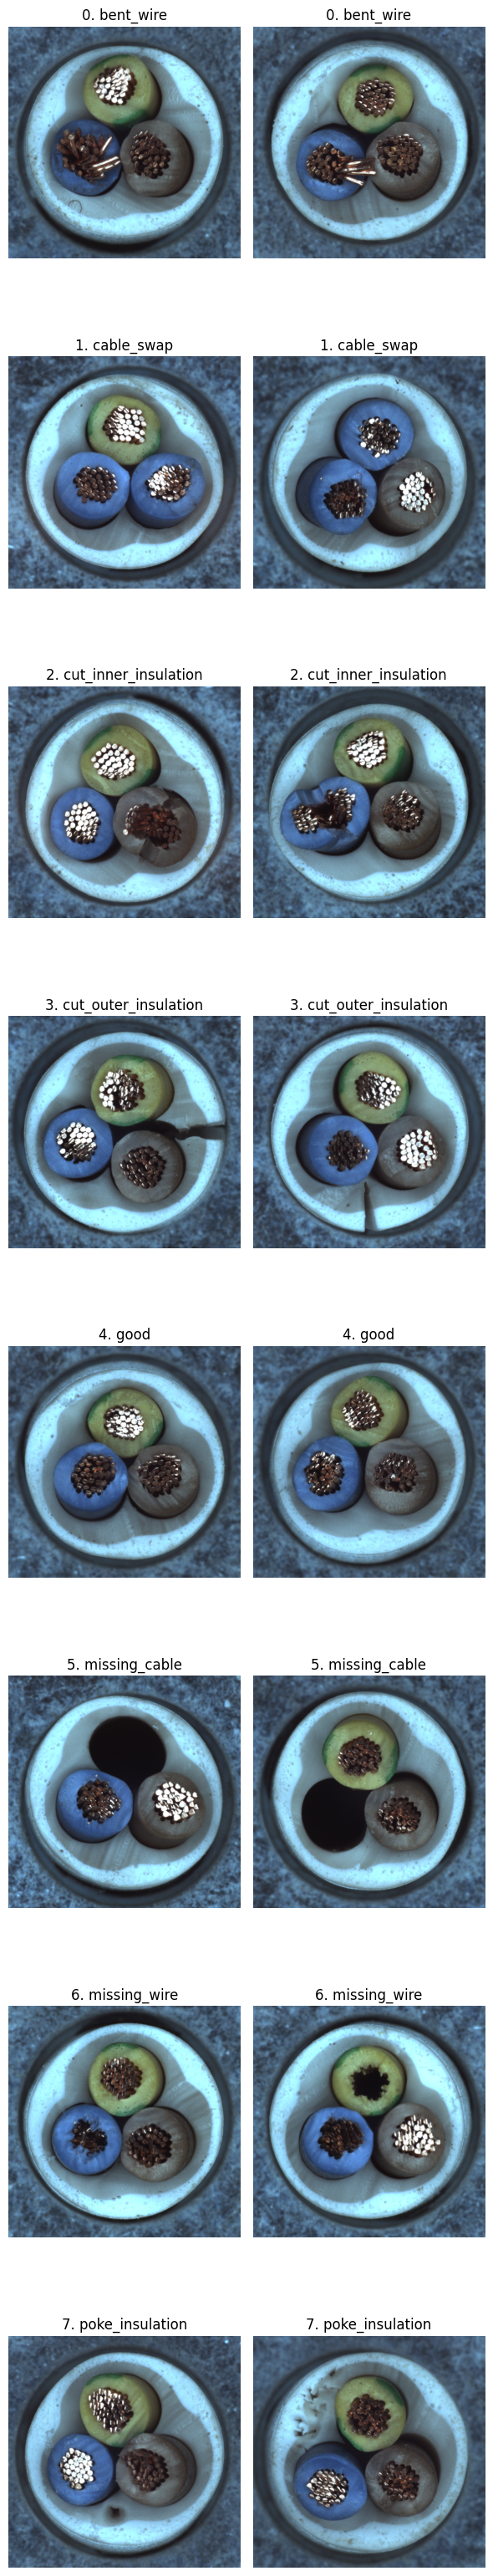

In [19]:
import matplotlib.pyplot as plt
import numpy as np

classes = sorted(set([path.split('/')[1] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

## A. Data Loading and Preprocessing

In [20]:
import torch
import numpy as np
import random
import os

import torch
import numpy as np
import random
import os

def set_random_seed(seed=42, deterministic=True):

    random.seed(seed)  # 設定 Python 內建的隨機數
    np.random.seed(seed)  # 設定 NumPy 隨機數
    torch.manual_seed(seed)  # 設定 PyTorch 隨機數

    # 如果使用 GPU，加上這些設定
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 針對多 GPU
    if deterministic:
        torch.backends.cudnn.deterministic = True  # 確保 CNN 的確定性
        torch.backends.cudnn.benchmark = False  # 避免非確定性優化

    # 設定 OS 環境變數，確保多線程應用一致
    os.environ['PYTHONHASHSEED'] = str(seed)

set_random_seed(42)


In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

num_classes = 8
images_per_class = 10
train_images_per_class = int(images_per_class * 0.8)
val_images_per_class = int(images_per_class * 0.2)

x_train = []
x_val = []

for i in range(num_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index:start_index + train_images_per_class])
    x_val.extend(all_data[start_index + train_images_per_class:start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_images_per_class, i) for i in range(num_classes)])
y_val = np.concatenate([np.full(val_images_per_class, i) for i in range(num_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_val.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_val.shape}')

Shape of x_train: (64, 3, 1024, 1024)
Shape of x_val: (16, 3, 1024, 1024)
Shape of y_train: (64,)
Shape of y_val: (16,)


In [22]:
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# ImageNet 的均值和標準差 (針對預訓練 ResNet)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# 訓練集的增強（包含隨機裁剪等，減少強增強）
train_transforms = transforms.Compose([
    # 隨機縮放裁剪，保證每張圖片都經過裁剪，且保持原圖比例
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    # 隨機水平翻轉
    transforms.RandomHorizontalFlip(),

    # 將圖像轉換為 tensor 並標準化
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),

    # 減少 RandomErasing 的強度
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3), value='random')
])

# 驗證集增強（僅裁剪和標準化）
val_transforms = transforms.Compose([
    # 將短邊調整為 256，保持比例縮放
    transforms.Resize(256),
    # 中心裁剪 224x224
    transforms.CenterCrop(224),
    # 轉換為 tensor 並標準化
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# 自定義數據集類
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # 將原始數據轉換為 PIL 圖像
        new_x = np.transpose(self.x[idx], (1, 2, 0))  # 轉換為 HWC 格式
        img = Image.fromarray(new_x)

        # 應用增強（如果有提供 transform）
        if self.transform:
            img = self.transform(img)

        return img, self.y[idx]

# 訓練和驗證數據加載器
# 假設你有 x_train, y_train, x_val, y_val 作為數據和標籤
train_dataset = MyDataset(x_train, y_train, transform=train_transforms)
val_dataset = MyDataset(x_val, y_val, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [23]:
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ----- GeM Pooling 定義 -----
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps)
        p = torch.clamp(self.p, min=0.1, max=6.0)
        x = x.pow(p)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.pow(1. / p)
        return x.flatten(1)

# ----- 建構模型 -----
def build_model(num_classes=8):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # 解凍 Layer3、Layer4，其餘固定
    for name, param in model.named_parameters():
        if "layer3" in name or "layer4" in name or "fc" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # 替換 avgpool 為 GeM pooling
    model.avgpool = GeM()

    # classifier: Dropout + Linear
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),  # 使用較為保守的 dropout 比率
        nn.Linear(num_ftrs, num_classes)
    )

    return model


## C. Training the Neural Network

In [25]:
!pip install warmup-scheduler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from tqdm.auto import tqdm

# 訓練參數
epochs = 50
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = -1

# Early Stopping 設定
patience = 5  # 設定最多容忍多少個epoch內沒有提升
patience_counter = 0  # 當前已經無提升的epoch數量
best_val_loss = float('inf')  # 記錄最佳的驗證集損失

# 建立模型與優化器
model = build_model(num_classes=8).cuda()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=4e-4, weight_decay=1e-4)

# Scheduler：CosineAnnealing + Warmup（共 5 epoch warmup）
warmup_epochs = 3
T_max = epochs - warmup_epochs  # Cosine 的 epoch 數量
scheduler_cosine = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1.0, total_epoch=warmup_epochs, after_scheduler=scheduler_cosine)

# 初始化 scheduler
scheduler.step()

for epoch in tqdm(range(epochs)):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda().long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_acc = 100. * correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda().long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100. * val_correct / val_total

    # Call scheduler.step() after each epoch
    scheduler.step()

    # Optionally, print or log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch {epoch+1}/{epochs}, Learning Rate: {current_lr}, Train Accuracy: {train_acc:.2f}%, Validation Accuracy: {val_acc:.2f}%')

    # 儲存最佳模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'model_classification.pth')
        patience_counter = 0  # 重設計數器
    else:
        patience_counter += 1  # 如果沒有提升，增加計數器

    # 如果驗證集損失沒有改進，則增加計數器
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    # 輸出訓練狀態
    print(f"[{epoch+1:02d}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}% | "
          f"LR: {current_lr:.6f}")

    # 記錄表現
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # 判斷是否提前停止訓練
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
        break
model.load_state_dict(torch.load('model_classification.pth'))
print("Model loaded successfully.")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Learning Rate: 0.0002666666666666667, Train Accuracy: 29.69%, Validation Accuracy: 12.50%
[01/50] Train Loss: 3.3555, Acc: 29.69% | Val Loss: 2.8050, Acc: 12.50% | LR: 0.000267
Epoch 2/50, Learning Rate: 0.0004, Train Accuracy: 26.56%, Validation Accuracy: 12.50%
[02/50] Train Loss: 3.4051, Acc: 26.56% | Val Loss: 2.8684, Acc: 12.50% | LR: 0.000400
Epoch 3/50, Learning Rate: 0.0004, Train Accuracy: 23.44%, Validation Accuracy: 18.75%
[03/50] Train Loss: 3.2049, Acc: 23.44% | Val Loss: 2.6529, Acc: 18.75% | LR: 0.000400
Epoch 4/50, Learning Rate: 0.0003995544922853191, Train Accuracy: 28.12%, Validation Accuracy: 37.50%
[04/50] Train Loss: 2.8134, Acc: 28.12% | Val Loss: 2.2102, Acc: 37.50% | LR: 0.000400
Epoch 5/50, Learning Rate: 0.00039821995888687865, Train Accuracy: 26.56%, Validation Accuracy: 37.50%
[05/50] Train Loss: 2.5550, Acc: 26.56% | Val Loss: 1.9321, Acc: 37.50% | LR: 0.000398
Epoch 6/50, Learning Rate: 0.00039600236015479906, Train Accuracy: 50.00%, Validatio

### Visualizing model performance

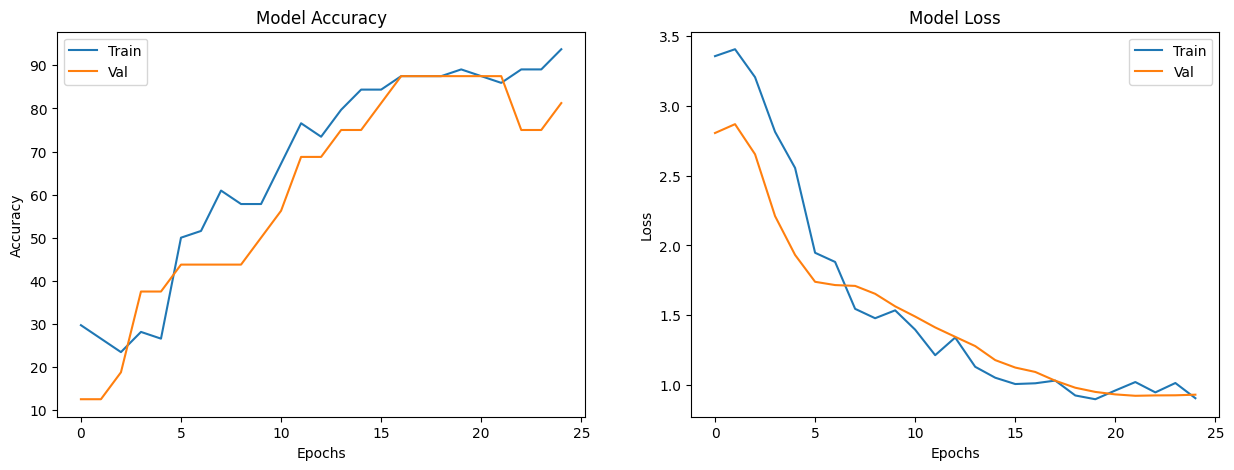

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [27]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

# Make sure the model is on the same device as the data
model = model.cuda()

test_correct = 0
test_total = 0

# Inference without gradient calculation
with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()  # Ensure data is on the same device as model
        labels = labels.cuda()  # Ensure labels are on the same device as model

        # Standardize images using ImageNet mean and std (assuming you're using a pretrained model)
        images = (images - torch.tensor(imagenet_mean).view(1, 3, 1, 1).cuda()) / torch.tensor(imagenet_std).view(1, 3, 1, 1).cuda()

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = outputs.max(1)  # Better practice than using .argmax(-1)

        # Accumulate correct predictions and total count
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

# Calculate accuracy
accuracy = 100. * test_correct / test_total
print(f'Test accuracy is {accuracy:.2f}%')


Test accuracy is 12.50%
